In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
from datetime import time
ticks_per_sec = 10000

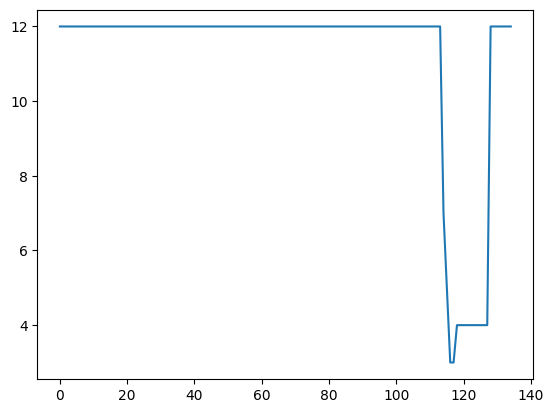

In [46]:
horusdf = pd.read_csv('/home/unknown/Backyard Flight/horus.csv')['satellites'].plot()

In [69]:
with open('/home/unknown/Camera/Clean/fastpayload.cap') as f:
    fastlines = f.readlines()
fast_bytes = bytearray()
for i, line in enumerate(fastlines):
    try:
        fast_bytes.extend(bytearray.fromhex(line))
    except:
        print(i)

In [482]:
fast_pacs = struct.iter_unpack('qffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff', fast_bytes)

def modify_pacs(pac):
    inner = []
    gyro_start = 3
    acc_start = 33
    for i in range(10):
        l = [pac[0] if i == 0 else None, pac[1], pac[2], pac[gyro_start], pac[gyro_start+1],pac[gyro_start+2], pac[acc_start], pac[acc_start+1],pac[acc_start+2]]
        gyro_start+=3
        acc_start+=3
        inner.append(l)
    return inner


fast_pacs = sorted(fast_pacs, key = lambda l : l[0])

fast_parts = [small for pac in fast_pacs for small in modify_pacs(pac) ]
fastdf = pd.DataFrame(fast_parts, columns=['timestamp', 'press', 'temp', 'gx', 'gy', 'gz', 'ax', 'ay', 'az'])

fastdf = fastdf[fastdf.timestamp!=-1].dropna(how='all').interpolate()
fastdf['seconds'] = fastdf.timestamp/1000000

In [550]:
single_rate = pd.DataFrame.from_records(fast_pacs, columns=['timestamp', 'press', 'temp', 'gx', 'gy', 'gz']+[('gyro'+str(i)) for i in range(27)]+['ax', 'ay', 'az']+[('acc'+str(i)) for i in range(27)])[['timestamp', 'press', 'temp', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']]


In [551]:
single_rate['seconds'] = single_rate.timestamp / 1000000
single_rate = single_rate.dropna()
single_rate = single_rate.copy()
single_rate['seconds'] -= single_rate['seconds'].min()


In [552]:
single_rate

,timestamp,press,temp,gx,gy,gz,ax,ay,az,seconds
2,1806933700,91.470772,35.108643,0.017944,-0.034437,0.003436,0.087338,-1.112064,-9.509675,0.000
3,1806943700,91.476387,35.113220,0.014660,-0.033444,0.027794,0.065802,-1.109073,-9.511469,0.010
4,1806953700,91.473068,35.108643,0.020845,-0.027717,0.023060,0.058624,-1.101894,-9.497711,0.020
5,1806963700,91.473068,35.108643,-0.004428,-0.020082,-0.012064,0.087338,-1.122233,-9.486345,0.030
6,1806973700,91.473068,35.108643,0.025961,-0.020616,-0.004352,0.056829,-1.144367,-9.487541,0.040
...,...,...,...,...,...,...,...,...,...,...
41499,2226028700,73.913330,35.895920,-0.148669,-0.087124,-2.501798,0.888933,0.468395,2.148156,419.095
41500,2226038700,73.894089,35.891342,-0.149661,-0.112399,-2.501798,0.808175,0.058624,1.945962,419.105
41501,2226048700,73.888031,35.895920,-0.162490,-0.063682,-2.501798,0.896112,0.471984,2.380260,419.115
41502,2226058700,73.875908,35.905075,-0.159206,-0.077121,-2.501798,0.669990,0.263808,2.117049,419.125


In [553]:
single_rate.iloc[40000:][['timestamp', 'press', 'temp', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']].to_csv('/home/unknown/Camera/single_rate.csv', index=False)

In [ ]:
fastdf[['gx', 'gy', 'gz']].

,gx,gy,gz
20,0.017944,-0.034437,0.003436
21,0.006108,-0.037262,0.023976
22,0.010842,-0.012980,-0.029168
23,0.015577,-0.041538,-0.045433
24,0.013209,-0.030161,0.038789
...,...,...,...
415035,-0.173943,-0.086590,-2.501798
415036,-0.146836,-0.080405,-2.501798
415037,-0.147294,-0.087582,-2.501798
415038,-0.134924,-0.084757,-2.501798


In [557]:
fastdf['seconds'] -= fastdf['seconds'].min()

In [486]:
fastdf[['seconds', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']].to_csv('/home/unknown/Camera/imu.csv', index=False)

In [71]:
fastdf.set_index('seconds')

,timestamp,press,temp,gx,gy,gz,ax,ay,az
seconds,,,,,,,,,
180693.37,1.806934e+09,91.470772,35.108643,0.017944,-0.034437,0.003436,0.087338,-1.112064,-9.509675
180693.47,1.806935e+09,91.470772,35.108643,0.006108,-0.037262,0.023976,0.068195,-1.104885,-9.500103
180693.57,1.806936e+09,91.470772,35.108643,0.010842,-0.012980,-0.029168,0.046061,-1.091725,-9.502496
180693.67,1.806937e+09,91.470772,35.108643,0.015577,-0.041538,-0.045433,0.082552,-1.132403,-9.500702
180693.77,1.806938e+09,91.470772,35.108643,0.013209,-0.030161,0.038789,0.069990,-1.137188,-9.474381
...,...,...,...,...,...,...,...,...,...
222606.87,2.226069e+09,73.862732,35.895920,-0.173943,-0.086590,-2.501798,0.943370,0.494716,2.062613
222606.87,2.226069e+09,73.862732,35.895920,-0.146836,-0.080405,-2.501798,1.051047,0.713061,2.116451
222606.87,2.226069e+09,73.862732,35.895920,-0.147294,-0.087582,-2.501798,0.927218,0.209970,2.030309


<Axes: >

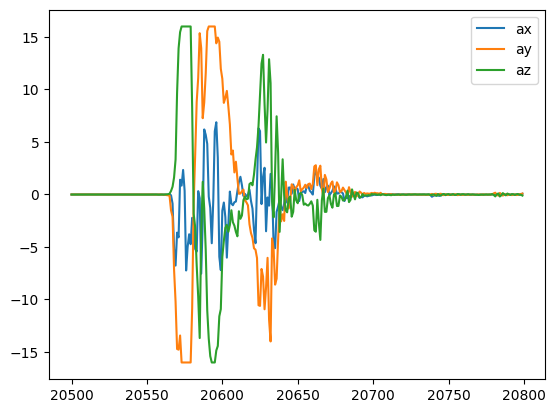

In [500]:
camdf[['ax', 'ay', 'az']].iloc[20500:20800].plot()

<Axes: >

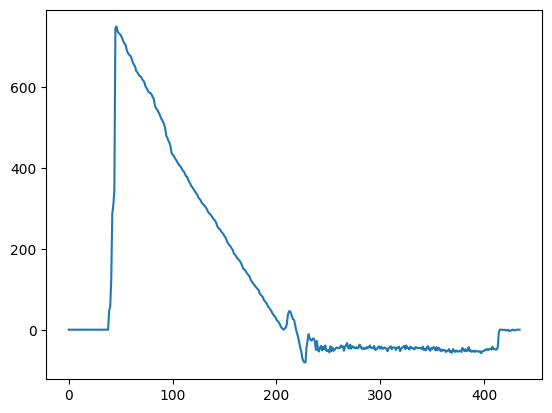

In [572]:
fdf2.VERTV.plot()

In [580]:
single_rate

,timestamp,press,temp,gx,gy,gz,ax,ay,az,seconds
2,1806933700,91.470772,35.108643,0.017944,-0.034437,0.003436,0.087338,-1.112064,-9.509675,0.000
3,1806943700,91.476387,35.113220,0.014660,-0.033444,0.027794,0.065802,-1.109073,-9.511469,0.010
4,1806953700,91.473068,35.108643,0.020845,-0.027717,0.023060,0.058624,-1.101894,-9.497711,0.020
5,1806963700,91.473068,35.108643,-0.004428,-0.020082,-0.012064,0.087338,-1.122233,-9.486345,0.030
6,1806973700,91.473068,35.108643,0.025961,-0.020616,-0.004352,0.056829,-1.144367,-9.487541,0.040
...,...,...,...,...,...,...,...,...,...,...
41499,2226028700,73.913330,35.895920,-0.148669,-0.087124,-2.501798,0.888933,0.468395,2.148156,419.095
41500,2226038700,73.894089,35.891342,-0.149661,-0.112399,-2.501798,0.808175,0.058624,1.945962,419.105
41501,2226048700,73.888031,35.895920,-0.162490,-0.063682,-2.501798,0.896112,0.471984,2.380260,419.115
41502,2226058700,73.875908,35.905075,-0.159206,-0.077121,-2.501798,0.669990,0.263808,2.117049,419.125


<Axes: xlabel='timestamp'>

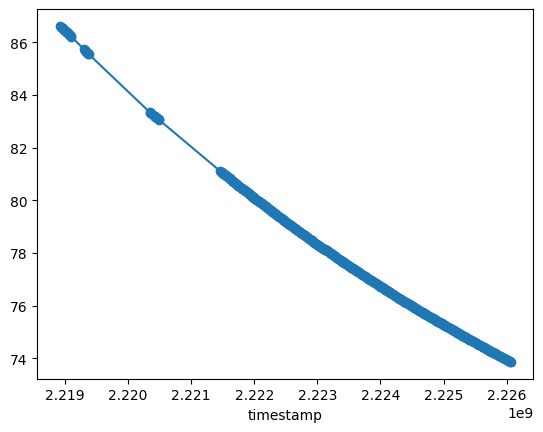

In [584]:
single_rate.set_index('timestamp').press.iloc[41000:].map(lambda press : press).plot(marker='o')

,timestamp,press,temp,gx,gy,gz,ax,ay,az,seconds
20,1.806934e+09,91.470772,35.108643,0.017944,-0.034437,0.003436,0.087338,-1.112064,-9.509675,0.000
21,1.806935e+09,91.470772,35.108643,0.006108,-0.037262,0.023976,0.068195,-1.104885,-9.500103,0.001
22,1.806936e+09,91.470772,35.108643,0.010842,-0.012980,-0.029168,0.046061,-1.091725,-9.502496,0.002
23,1.806937e+09,91.470772,35.108643,0.015577,-0.041538,-0.045433,0.082552,-1.132403,-9.500702,0.003
24,1.806938e+09,91.470772,35.108643,0.013209,-0.030161,0.038789,0.069990,-1.137188,-9.474381,0.004
...,...,...,...,...,...,...,...,...,...,...
415035,2.226069e+09,73.862732,35.895920,-0.173943,-0.086590,-2.501798,0.943370,0.494716,2.062613,419.135
415036,2.226069e+09,73.862732,35.895920,-0.146836,-0.080405,-2.501798,1.051047,0.713061,2.116451,419.135
415037,2.226069e+09,73.862732,35.895920,-0.147294,-0.087582,-2.501798,0.927218,0.209970,2.030309,419.135
415038,2.226069e+09,73.862732,35.895920,-0.134924,-0.084757,-2.501798,1.107278,0.849452,2.079961,419.135


<Axes: xlabel='UNIXTIME'>

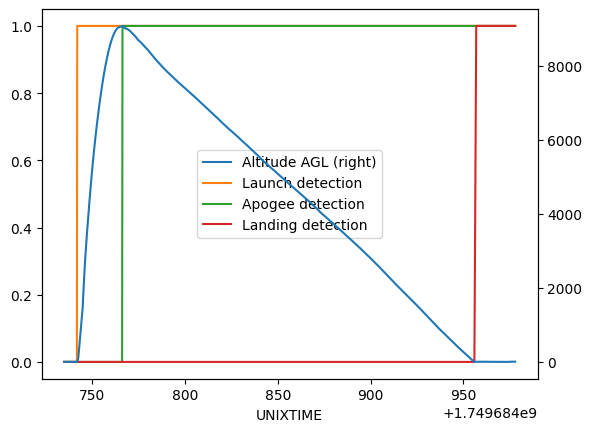

In [510]:
fdf2.set_index('UNIXTIME')[['Altitude AGL', 'Launch detection', 'Apogee detection', 'Landing detection']].astype(float).plot(secondary_y = 'Altitude AGL')

In [514]:
changed = fdf2[['Launch detection', 'Apogee detection', 'Landing detection']].diff()

In [516]:
launch = changed[changed['Launch detection'] == True].iloc[0].name
apogee = changed[changed['Apogee detection'] == True].iloc[0].name
landing = changed[changed['Landing detection'] == True].iloc[0].name

In [517]:
launch, apogee, landing

(39, 217, 415)

<Axes: title={'center': 'CTRL FREAK Accelerometer Data'}, xlabel='timestamp', ylabel='m/s^2'>

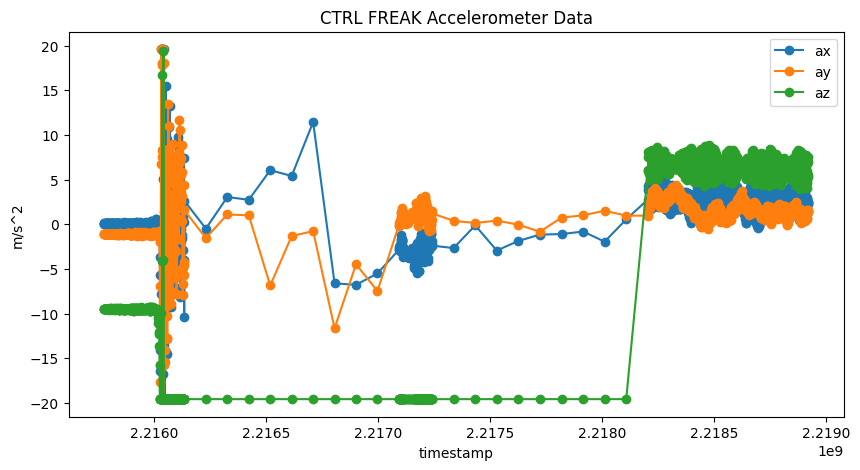

In [547]:
fastdf.iloc[408800:410000].set_index('timestamp')[['ax', 'ay', 'az']].plot(figsize=(10,5), title="CTRL FREAK Accelerometer Data", ylabel="m/s^2", marker='o')

In [ ]:
fastdf.iloc[408800:410000].set_index('timestamp')[['ax', 'ay', 'az']].plot(figsize=(10,5), title="CTRL FREAK Accelerometer Data", ylabel="m/s^2", marker='o')

In [76]:
import numpy as np

In [77]:
fastdf['acc_mag'] = np.sqrt(fastdf.ax * fastdf.ax + fastdf.ay * fastdf.ay + fastdf.az * fastdf.az)

<Axes: >

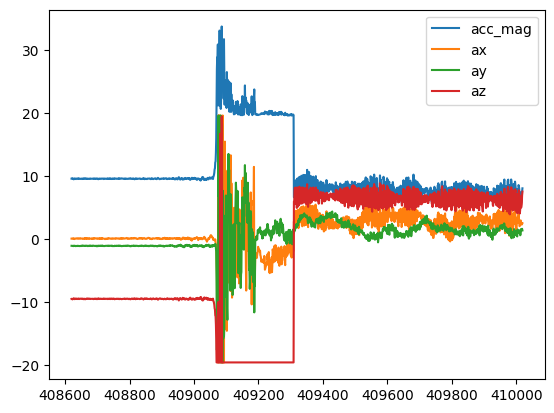

In [78]:
fastdf[['acc_mag', 'ax', 'ay', 'az']].iloc[408600:410000].plot()

In [124]:
fastdf.reset_index()[['ax', 'ay', 'az']].iloc[408000:409000].plot(x='timestamp')

KeyError: 'timestamp'

In [127]:
fastdf.reset_index()[['second','az']].iloc[408000:410000].plot(x='timestamp')

KeyError: "['second'] not in index"

In [67]:
fastdf[['ax','ay','az']].iloc[408000:].plot(figsize=(22,9))

NameError: name 'fastdf' is not defined

<Axes: >

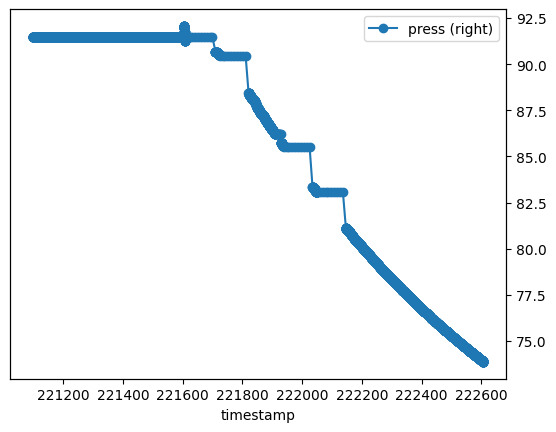

In [118]:
fastdf[['timestamp','press']].iloc[404000:].plot(x='timestamp', secondary_y='press', marker = 'o')

In [320]:
fastdf['seconds'] = fastdf['timestamp']/10000 - (fastdf['timestamp'].min()/10000)

<Axes: xlabel='seconds'>

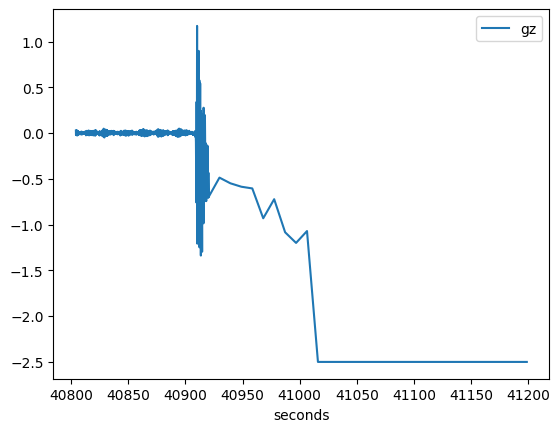

In [343]:
fastdf[['seconds', 'gz']].iloc[408000:410000].plot(x='seconds')

In [89]:

with open('/home/unknown/Camera/Clean/slow.cap') as f:
    slowlines = f.readlines()
slow_bytes = bytearray()
for line in slowlines:
    slow_bytes.extend(bytearray.fromhex(line))

In [90]:
slowdf

NameError: name 'slowdf' is not defined

In [518]:
slow_pacs = struct.iter_unpack('<qQhhbbbBBBHHBB', slow_bytes)
slowdf = pd.DataFrame.from_records(slow_pacs, columns=['timestamp', 'packed', 'latfrac', 'lonfrac', 'ox', 'oy', 'oz', 'flight_state', 'o2', 'o3', 'voltage', 'current', 'temp', 'flip_status'])


In [519]:

slowdf =slowdf.iloc[:1039]

voltage_base = 6.75; # 6.75 to 9.25
voltage_scale = 100; # 2.5 volt range to 250 volt range
lat_int = 31
long_int = -102

slowdf.ox = slowdf.ox.map(lambda i8 : i8/127)
slowdf.oy = slowdf.oy.map(lambda i8 : i8/127)
slowdf.oz = slowdf.oz.map(lambda i8 : i8/127)


slowdf.voltage = (slowdf.voltage / voltage_scale) + voltage_base

slowdf.timestamp = slowdf.timestamp/10000
# slowdf.timestamp = slowdf.timestamp/ticks_per_sec

flight_state_to_str = ['NotSet', 'OnPad', 'Boost', 'Flight', 'InitialRoll', 'InitialPump', 'Continous']
slowdf.flight_state = slowdf.flight_state.map(lambda fs : flight_state_to_str[int(fs)])

In [533]:
MILLIS_LOC, MILLIS_MASK = 1, 0b111111111111111111111111111
SATS_LOC, SATS_MASK = 28, 0b1111

SPEED_LOC, SPEED_MASK = 40, 0b1111111111
ALT_LOC, ALT_MASK = 50, 0b11111111111111

STAT_LOC, STAT_MASK = 35, 0b11
QUAL_LOC, QUAL_MASK = 32, 0b11


def unpack_gps(u64):
    u64 = int(u64)
    as_millis = (u64 >> MILLIS_LOC) & MILLIS_MASK
    ms = as_millis % 1000
    as_sec = as_millis // 1000
    sec = as_sec % 60
    as_min = as_sec // 60
    min = as_min % 60
    hr = as_min // 60

    sats = (u64 >> SATS_LOC) & SATS_MASK

    speed = (u64 >> SPEED_LOC) & SPEED_MASK
    alt = (u64 >> ALT_LOC) & ALT_MASK

    if hr > 0:
        hr -= 1 
    t = time(hr, min, sec)

    stat = (u64 >> STAT_LOC) & STAT_MASK
    qual = (u64 >> QUAL_LOC) & QUAL_MASK
    

    return t, as_sec, sats, speed, alt, stat, qual

In [534]:
slowdf[['time', 'sec', 'sats', 'gps_speed', 'gps_alt', 'gps_status', 'gps_quality']] = slowdf.apply(lambda r : unpack_gps(r.packed), axis=1, result_type='expand')

<Axes: >

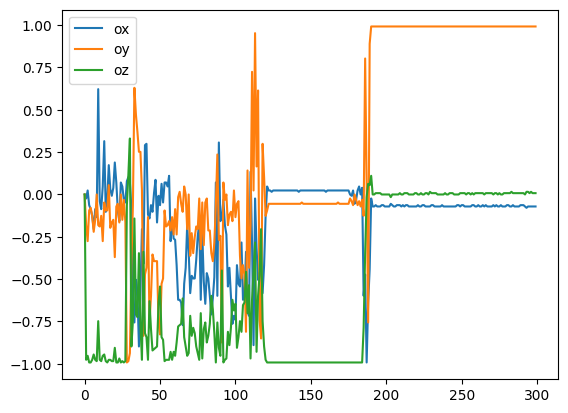

In [530]:
slowdf[['ox','oy','oz']].iloc[:300].plot()

<Axes: >

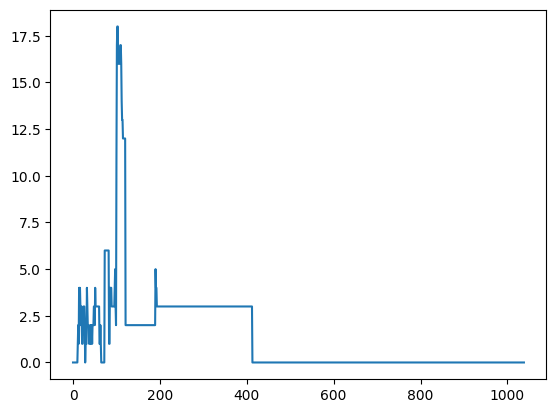

In [96]:
slowdf['gps_speed'].plot()

In [ ]:
slowdf

,timestamp,packed,latfrac,lonfrac,ox,oy,oz,flight_state,o2,o3,voltage,current,temp,flip_status,time,sec,sats,gps_speed,gps_alt
0,1.9980,0,0,0,0.000000,0.000000,0.000000,NotSet,175,8,7.54,81,33,240,00:00:00,0,0,0,0
1,2.9980,0,0,0,-0.023622,-0.181102,-0.976378,OnPad,133,214,8.23,0,27,255,00:00:00,0,0,0,0
2,3.7387,3149142080648352096,0,0,0.023622,-0.275591,-0.952756,OnPad,122,32,8.23,0,27,255,19:17:34,69454,9,0,2797
3,4.7495,3209940676423162160,0,0,-0.062992,-0.094488,-0.992126,OnPad,146,55,8.23,0,27,255,19:17:35,69455,12,0,2851
4,5.7683,3245969473442128128,0,0,-0.086614,-0.078740,-0.992126,OnPad,114,165,8.23,0,27,255,19:17:36,69456,12,0,2883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,1035.6268,3247095412005710416,0,0,0.212598,-0.968504,0.007874,Continous,187,180,8.21,0,42,255,19:34:33,70473,12,0,2884
1035,1036.6385,3247095412005712416,0,0,0.212598,-0.968504,0.007874,Continous,74,112,8.21,0,42,255,19:34:34,70474,12,0,2884
1036,1037.6707,3247095412005714416,0,0,0.212598,-0.968504,0.007874,Continous,148,120,8.21,0,42,255,19:34:35,70475,12,0,2884
1037,1038.6695,3247095412005716416,0,0,0.212598,-0.968504,0.007874,Continous,54,246,8.21,0,42,255,19:34:36,70476,12,0,2884


<Axes: >

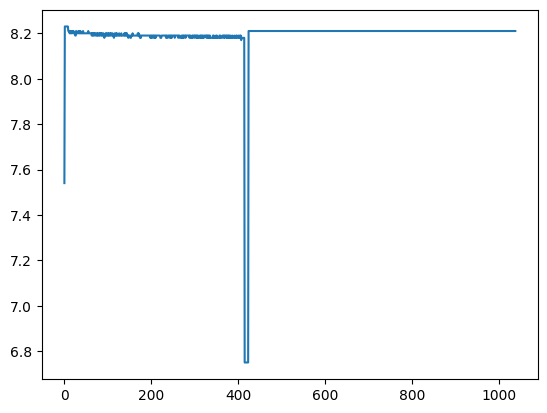

In [ ]:
slowdf.voltage.plot()

In [535]:
slowdf.to_csv('/home/unknown/Clubs/Launch/Misc/flight-data/2025/LOTUS/ControlFreak/CSVs/freaky_slow.csv')

In [ ]:
slowdf.gps_alt.iloc[2:100]

2     2797
3     2851
4     2883
5     2886
6     2893
      ... 
95    2729
96    2776
97    2777
98    2783
99    2800
Name: gps_alt, Length: 98, dtype: int64

In [ ]:
slowdf['gps_alt'].filter(lambda r : r['']).plot()

TypeError: Index(...) must be called with a collection of some kind, <function <lambda> at 0x74d33c1b6160> was passed

In [98]:
snodupe

,timestamp,packed,latfrac,lonfrac,ox,oy,oz,flight_state,o2,o3,voltage,current,temp,flip_status,time,sec,sats,gps_speed,gps_alt
0,1.9980,0,0,0,0.000000,0.000000,0.000000,NotSet,175,8,7.54,81,33,240,00:00:00,0,0,0,0
2,3.7387,3149142080648352096,0,0,0.023622,-0.275591,-0.952756,OnPad,122,32,8.23,0,27,255,19:17:34,69454,9,0,2797
3,4.7495,3209940676423162160,0,0,-0.062992,-0.094488,-0.992126,OnPad,146,55,8.23,0,27,255,19:17:35,69455,12,0,2851
4,5.7683,3245969473442128128,0,0,-0.086614,-0.078740,-0.992126,OnPad,114,165,8.23,0,27,255,19:17:36,69456,12,0,2883
5,6.7548,3249347173162658000,0,0,-0.125984,-0.125984,-0.976378,OnPad,90,216,8.23,0,27,255,19:17:37,69457,12,0,2886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,1035.6268,3247095412005710416,0,0,0.212598,-0.968504,0.007874,Continous,187,180,8.21,0,42,255,19:34:33,70473,12,0,2884
1035,1036.6385,3247095412005712416,0,0,0.212598,-0.968504,0.007874,Continous,74,112,8.21,0,42,255,19:34:34,70474,12,0,2884
1036,1037.6707,3247095412005714416,0,0,0.212598,-0.968504,0.007874,Continous,148,120,8.21,0,42,255,19:34:35,70475,12,0,2884
1037,1038.6695,3247095412005716416,0,0,0.212598,-0.968504,0.007874,Continous,54,246,8.21,0,42,255,19:34:36,70476,12,0,2884


<Axes: >

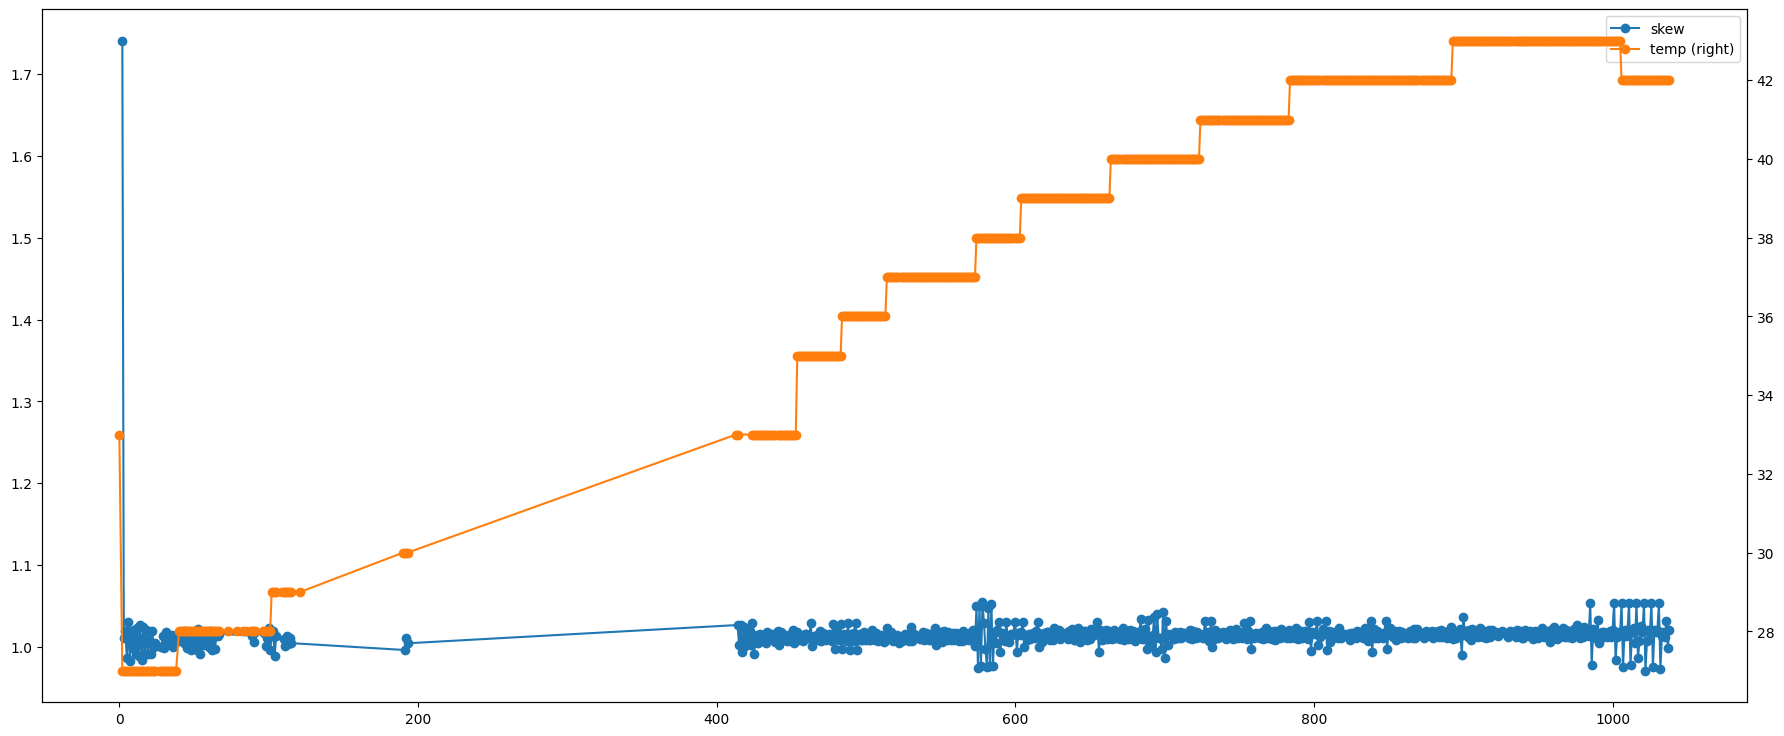

In [119]:
snodupe = slowdf.drop_duplicates('sec')

skewdf = snodupe[['timestamp']].diff().rolling(1).mean().rename(columns={'timestamp':'skew'})
ax = skewdf[skewdf['skew'] < 2].plot(figsize=(22,9), marker='o')
snodupe[snodupe['temp'] > 0][['temp']].plot(ax=ax, secondary_y=True, marker='o')

<Axes: >

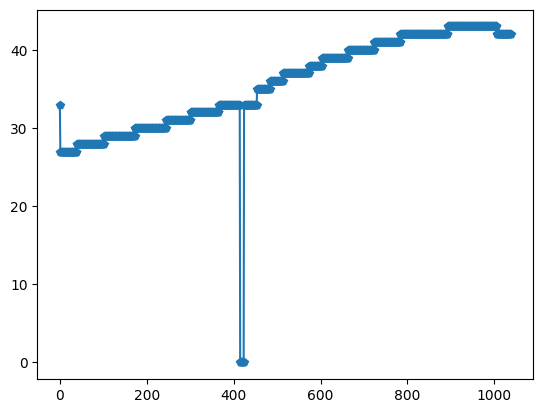

In [123]:
slowdf['temp'].plot(marker='p')

In [ ]:
with open('/home/unknown/Camera/Split4g_0009.gcsv', 'r') as f:
    src = f.read()

In [ ]:
fdf = pd.read_csv('/home/unknown/Camera/Real/_T144RITg2__06-11-2025_12_55_34.csv')

In [ ]:
fdf['time'] = pd.to_datetime(fdf.TIME)

/tmp/ipykernel_49435/2960655180.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fdf['time'] = pd.to_datetime(fdf.TIME)


<Axes: xlabel='time'>

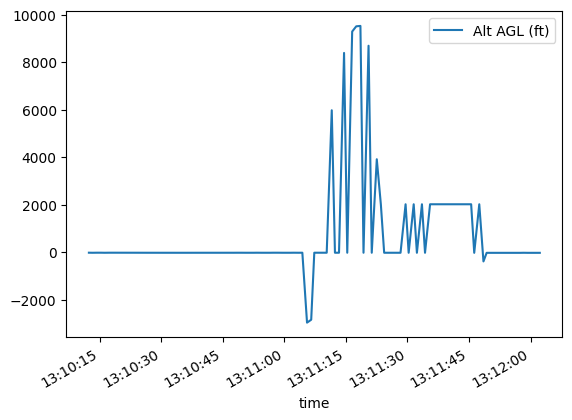

In [ ]:
fdf[['time', 'Alt AGL (ft)']].iloc[840:950].plot(x='time')

In [ ]:
fdf

,TRACKER,DATE,TIME,GS Lat,GS Lon,GS Alt asl,TRACKER Lat,TRACKER Lon,TRACKER Alt asl,FIX,...,Up Rccvd,Found rocket ID,Found rocket lat,Found rocket lon,Found rocket altitude,Found rocket fix,Found rocket batt_v,Found RSSI,GS_ASL_offset,time
0,<T144RITpl>,2025-06-11,12:55:34.179,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:34.179
1,<T144RITpl>,2025-06-11,12:55:35.167,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:35.167
2,<T144RITpl>,2025-06-11,12:55:36.127,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:36.127
3,<T144RITpl>,2025-06-11,12:55:37.149,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:37.149
4,<T144RITpl>,2025-06-11,12:55:38.138,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:38.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,<T144RITpl>,2025-06-11,13:36:07.838,31.03770,-103.53701,2954.3,31.03811,-103.53814,2937.6,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:07.838
2119,<T144RITpl>,2025-06-11,13:36:09.080,31.03770,-103.53701,2954.3,31.03811,-103.53813,2936.2,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:09.080
2120,<T144RITpl>,2025-06-11,13:36:10.108,31.03765,-103.53696,2955.8,31.03811,-103.53813,2935.0,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:10.108
2121,<T144RITpl>,2025-06-11,13:36:10.792,31.03762,-103.53696,2960.4,31.03811,-103.53813,2935.8,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:10.792


In [129]:
pfdf

,TRACKER,DATE,TIME,GS Lat,GS Lon,GS Alt asl,TRACKER Lat,TRACKER Lon,TRACKER Alt asl,FIX,...,Up Rccvd,Found rocket ID,Found rocket lat,Found rocket lon,Found rocket altitude,Found rocket fix,Found rocket batt_v,Found RSSI,GS_ASL_offset,time
0,<T144RITpl>,2025-06-11,12:55:34.179,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:34.179
1,<T144RITpl>,2025-06-11,12:55:35.167,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:35.167
2,<T144RITpl>,2025-06-11,12:55:36.127,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:36.127
3,<T144RITpl>,2025-06-11,12:55:37.149,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:37.149
4,<T144RITpl>,2025-06-11,12:55:38.138,31.03761,-103.53695,2962.7,0.00000,0.00000,0.0,0,...,0,NaN,0.00000,0.00000,0.0,0,0.000,-50,0.0,2025-06-11 12:55:38.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,<T144RITpl>,2025-06-11,13:36:07.838,31.03770,-103.53701,2954.3,31.03811,-103.53814,2937.6,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:07.838
2119,<T144RITpl>,2025-06-11,13:36:09.080,31.03770,-103.53701,2954.3,31.03811,-103.53813,2936.2,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:09.080
2120,<T144RITpl>,2025-06-11,13:36:10.108,31.03765,-103.53696,2955.8,31.03811,-103.53813,2935.0,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:10.108
2121,<T144RITpl>,2025-06-11,13:36:10.792,31.03762,-103.53696,2960.4,31.03811,-103.53813,2935.8,3,...,14,140-Tracker,31.03522,-103.51934,2929.9,3,4.123,-103,0.0,2025-06-11 13:36:10.792


[]

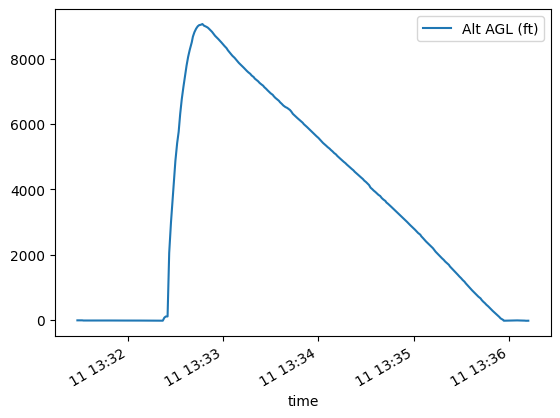

In [124]:
pfdf = fdf[fdf.TRACKER=='<T144RITpl>']
ax = pfdf[['time', 'Alt AGL (ft)']].iloc[1600:].plot(x='time')



start = fdf.iloc[1630]
end = fdf.iloc[1650]
ax.plot(xs=[start.TIME, end.TIME], ys=[start['Alt AGL (ft)'], end['Alt AGL (ft)']], **{'color': 'lightsteelblue', 'marker': 'o'})



In [126]:
from scipy.differentiate import derivative

In [147]:
pfdf = pfdf.copy()

In [148]:

pfdf['seconds'] = pd.to_timedelta(pfdf.TIME).map(lambda ts : ts.total_seconds())

In [165]:
pfdf['vel_deriv'] = (pfdf['Alt AGL (ft)'].diff() / pfdf.seconds.diff())
pfdf['vel_deriv_sm'] = (pfdf['Alt AGL (ft)'].diff() / pfdf.seconds.diff()).rolling(2).mean()


In [166]:
pfdf['acc_deriv'] = (pfdf.vel_deriv.diff() / pfdf.seconds.diff())
pfdf['acc_deriv_sm'] = (pfdf.vel_deriv_sm.diff() / pfdf.seconds.diff())
pfdf['acc_deriv_sm2'] = (pfdf.vel_deriv_sm.diff() / pfdf.seconds.diff()).rolling(2).mean()

<Axes: >

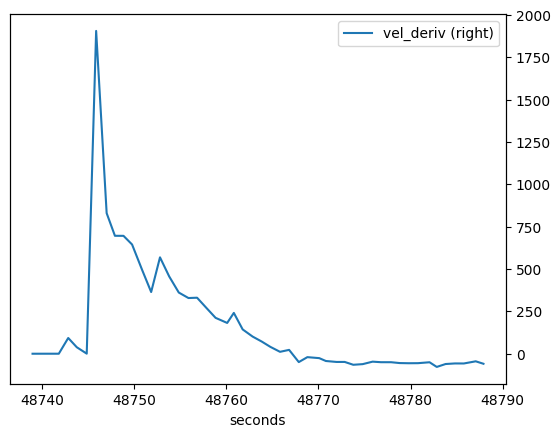

In [174]:
pfdf[['seconds','vel_deriv']].iloc[1650:1700].plot(x='seconds', secondary_y='vel_deriv')

In [131]:
def derivate(serie):
    df1 = (serie.diff() / serie.index.to_series().diff().dt.total_seconds()).dropna()
    df1.index = serie.index[0:-1]
    return df1

In [ ]:
pfdf.iloc[1600:].to_csv('/home/unknown/featherwait_payload_flight.csv')

In [ ]:
derivate()

In [ ]:
fdf[fdf.TRACKER=='<T144RITpl>'][['time', 'Alt AGL (ft)']]['Alt AGL (ft)'].max()

9069.353

<Axes: title={'center': 'Rocket Featherweight Altitude'}, xlabel='time'>

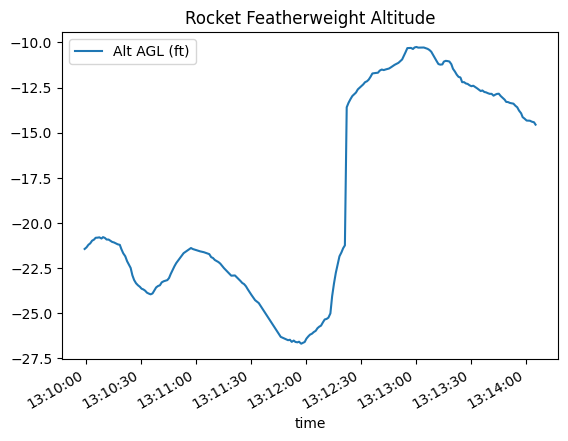

In [ ]:
fdf[fdf.TRACKER=='<T144RITrk>'][['time', 'Alt AGL (ft)']].plot(x='time', title='Rocket Featherweight Altitude')

In [ ]:
fdf.TRACKER.unique()

array(['<T144RITpl>', '<T144RITrk>', '<T144RITg1>', 'arch nose'],
      dtype=object)

In [ ]:
with open('/home/unknown/Camera/Clean/receiver.cap', 'r') as f:
    lines = f.readlines()

In [ ]:
fdf2 = pd.read_csv('/home/unknown/Downloads/_T144RITpl__06-11-2025_13_32_24 (1).csv')

In [211]:
fdf2

,UTCTIME,UNIXTIME,ALT,LAT,LON,#SATS,FIX,HORZV,VERTV,HEAD,...,>32,>24,RSSI,BATT,Altitude AGL,Launch detection,Apogee detection,Landing detection,Distance (feet),vel_diff
0,Jun 11 2025 18:32:14.799 UTC,1.749685e+09,2938.8,31.04430,-103.53507,31,3,0,0,-151,...,17,2,-48,4.087,0.8,False,False,False,0.3118,NaN
1,Jun 11 2025 18:32:15.000 UTC,1.749685e+09,2938.7,31.04430,-103.53507,31,3,0,0,-12,...,17,2,-48,4.087,0.7,False,False,False,0.3118,-0.497512
2,Jun 11 2025 18:32:15.199 UTC,1.749685e+09,2938.7,31.04430,-103.53507,31,3,0,0,-119,...,17,2,-48,4.087,0.7,False,False,False,0.3118,0.000000
3,Jun 11 2025 18:32:15.399 UTC,1.749685e+09,2938.6,31.04430,-103.53507,31,3,0,0,0,...,17,2,-48,4.087,0.6,False,False,False,0.3118,-0.500000
4,Jun 11 2025 18:32:15.499 UTC,1.749685e+09,2938.6,31.04430,-103.53507,31,3,0,0,-127,...,18,2,-48,4.087,0.6,False,False,False,0.3118,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,Jun 11 2025 18:36:14.000 UTC,1.749685e+09,2936.7,31.03813,-103.53812,32,3,0,-1,-60,...,0,2,-52,4.082,-1.3,True,True,True,2449.4375,-0.800000
431,Jun 11 2025 18:36:15.000 UTC,1.749685e+09,2939.9,31.03813,-103.53813,32,3,0,0,-148,...,0,2,-52,4.082,1.9,True,True,True,2449.7280,3.200000
432,Jun 11 2025 18:36:17.000 UTC,1.749685e+09,2942.5,31.03813,-103.53812,32,3,0,0,33,...,0,2,-52,4.082,4.5,True,True,True,2448.1546,1.300000
433,Jun 11 2025 18:36:18.000 UTC,1.749685e+09,2943.0,31.03813,-103.53812,32,3,0,0,-116,...,0,2,-52,4.082,5.0,True,True,True,2448.1546,0.500000


In [214]:
fdf2['ACC'] = fdf2['VERTV'].diff() / fdf2['UNIXTIME'].diff()

<Axes: xlabel='UNIXTIME'>

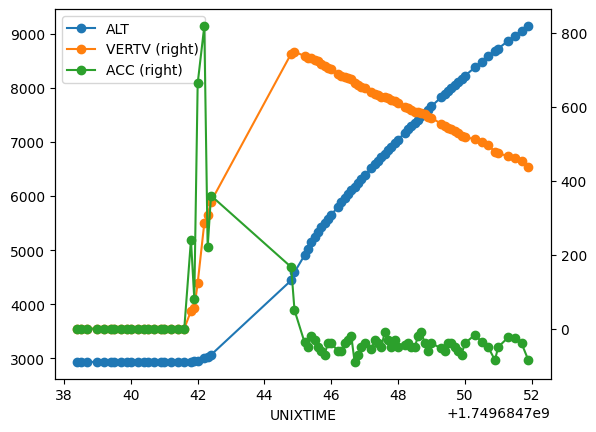

In [222]:
fdf2[['ALT','VERTV', 'ACC', 'UNIXTIME']].iloc[20:100].plot(x='UNIXTIME', secondary_y=['VERTV', 'ACC'], marker='o')

<Axes: xlabel='UNIXTIME'>

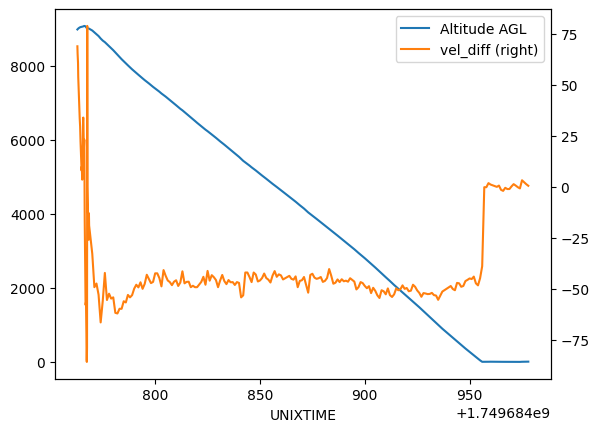

In [203]:
fdf2['vel_diff'] = (fdf2['Altitude AGL'].diff()/ fdf2.UNIXTIME.diff())
fdf2.set_index('UNIXTIME')[['Altitude AGL', 'vel_diff']].iloc[190:440].plot(secondary_y='vel_diff')

<Axes: xlabel='UNIXTIME'>

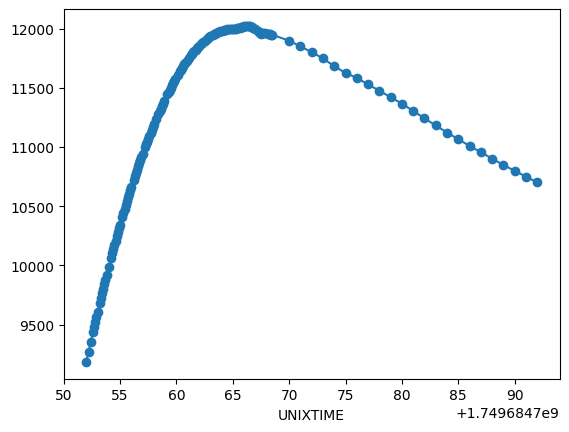

In [185]:
fdf2.set_index('UNIXTIME')['ALT'].iloc[100:260].plot(marker='o')

In [ ]:
fdf2.set_index('UNIXTIME')

,UTCTIME,ALT,LAT,LON,#SATS,FIX,HORZV,VERTV,HEAD,FLAGS,>40,>32,>24,RSSI,BATT,Altitude AGL,Launch detection,Apogee detection,Landing detection,Distance (feet)
UNIXTIME,,,,,,,,,,,,,,,,,,,,
1.749685e+09,Jun 11 2025 18:32:14.799 UTC,2938.8,31.04430,-103.53507,31,3,0,0,-151,3,4,17,2,-48,4.087,0.8,False,False,False,0.3118
1.749685e+09,Jun 11 2025 18:32:15.000 UTC,2938.7,31.04430,-103.53507,31,3,0,0,-12,3,4,17,2,-48,4.087,0.7,False,False,False,0.3118
1.749685e+09,Jun 11 2025 18:32:15.199 UTC,2938.7,31.04430,-103.53507,31,3,0,0,-119,3,4,17,2,-48,4.087,0.7,False,False,False,0.3118
1.749685e+09,Jun 11 2025 18:32:15.399 UTC,2938.6,31.04430,-103.53507,31,3,0,0,0,3,4,17,2,-48,4.087,0.6,False,False,False,0.3118
1.749685e+09,Jun 11 2025 18:32:15.499 UTC,2938.6,31.04430,-103.53507,31,3,0,0,-127,3,3,18,2,-48,4.087,0.6,False,False,False,0.3118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.749685e+09,Jun 11 2025 18:36:14.000 UTC,2936.7,31.03813,-103.53812,32,3,0,-1,-60,3,0,0,2,-52,4.082,-1.3,True,True,True,2449.4375
1.749685e+09,Jun 11 2025 18:36:15.000 UTC,2939.9,31.03813,-103.53813,32,3,0,0,-148,3,0,0,2,-52,4.082,1.9,True,True,True,2449.7280
1.749685e+09,Jun 11 2025 18:36:17.000 UTC,2942.5,31.03813,-103.53812,32,3,0,0,33,3,0,0,2,-52,4.082,4.5,True,True,True,2448.1546


<Axes: >

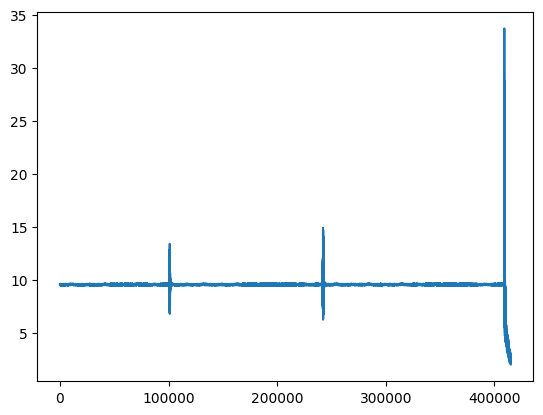

In [176]:
fastdf['acc_mag'].plot()

In [223]:
with open('/home/unknown/Camera/Clean/receiver.cap', 'r') as f:
    lines = f.readlines()

In [234]:
base = bytearray()
for l in lines:
    base.extend(bytearray.fromhex(''.join(l.split(' ')[2:18])))

In [239]:
received_packets = list(struct.iter_unpack('=bhHHBBBffHBBbBBBBBBBBBBH', base))

In [242]:
rdf = pd.DataFrame.from_records(received_packets, columns=['snr', 'rssi', 'payload_id', 'seq_num', 'hours', 'minutes', 'seconds', 'latitude', 'longitude', 'altitude', 'speed', 'sats', 'temperature', 'battery_voltage', 'c1', 'c2', 'c3','c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'checksum']).drop('checksum', axis=1)

In [263]:
rdf

,snr,rssi,payload_id,seq_num,hours,minutes,seconds,latitude,longitude,altitude,...,battery_voltage,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,-14,-100,388,5,17,56,39,31.044306,-103.535080,898,...,209,1,242,130,0,190,35,0,1,0
1,-12,-100,388,7,17,57,0,31.044300,-103.535080,898,...,209,1,241,130,0,190,35,0,1,0
2,-12,-99,388,9,17,57,30,31.044298,-103.535072,897,...,209,1,242,130,0,190,35,0,1,0
3,-12,-97,388,11,17,58,0,31.044302,-103.535072,897,...,209,0,242,130,0,188,35,0,1,0
4,-20,-108,388,13,17,58,30,31.044306,-103.535072,897,...,209,1,241,130,0,190,35,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,5,-78,388,161,18,35,29,31.038233,-103.536949,1686,...,205,254,243,130,0,233,33,0,5,0
76,-19,-106,388,167,18,36,59,31.038355,-87.538269,814,...,207,131,3,238,0,182,35,0,5,0
77,-21,-107,388,169,18,37,30,31.038275,-103.538155,867,...,206,131,0,238,0,181,35,0,5,0
78,-20,-107,388,173,18,38,30,31.038145,-103.538124,903,...,207,131,2,237,0,181,35,0,5,0


In [277]:
rdf['pressure'] = rdf.apply(lambda r  : (int(r['c5']) | (int(r['c6']) << 8))/100.0, axis=1)

In [281]:
flight_state_to_str

['NotSet',
 'OnPad',
 'Boost',
 'Flight',
 'InitialRoll',
 'InitialPump',
 'Continous']

In [283]:
rdf

,snr,rssi,payload_id,seq_num,hours,minutes,seconds,latitude,longitude,altitude,...,c1,c2,c3,c4,c5,c6,c7,c8,c9,pressure
0,-14,-100,388,5,17,56,39,31.044306,-103.535080,898,...,1,242,130,0,190,35,0,1,0,91.50
1,-12,-100,388,7,17,57,0,31.044300,-103.535080,898,...,1,241,130,0,190,35,0,1,0,91.50
2,-12,-99,388,9,17,57,30,31.044298,-103.535072,897,...,1,242,130,0,190,35,0,1,0,91.50
3,-12,-97,388,11,17,58,0,31.044302,-103.535072,897,...,0,242,130,0,188,35,0,1,0,91.48
4,-20,-108,388,13,17,58,30,31.044306,-103.535072,897,...,1,241,130,0,190,35,0,1,0,91.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,5,-78,388,161,18,35,29,31.038233,-103.536949,1686,...,254,243,130,0,233,33,0,5,0,86.81
76,-19,-106,388,167,18,36,59,31.038355,-87.538269,814,...,131,3,238,0,182,35,0,5,0,91.42
77,-21,-107,388,169,18,37,30,31.038275,-103.538155,867,...,131,0,238,0,181,35,0,5,0,91.41
78,-20,-107,388,173,18,38,30,31.038145,-103.538124,903,...,131,2,237,0,181,35,0,5,0,91.41


In [285]:
rdf['flight_state'] = rdf['c8'].map(lambda x : flight_state_to_str[int(x)])

In [ ]:
from datetime  import time

In [289]:
rdf['time'] = rdf.apply(lambda r : time(r['hours'], r['minutes'], r['seconds']) , axis=1)

In [295]:
rdf['voltage'] = rdf.battery_voltage.map(lambda i : 10 * i / 255)

In [298]:
rdf[['time', 'snr', 'rssi', 'payload_id', 'hours', 'latitude', 'longitude', 'altitude', 'speed', 'sats', 'temperature', 'voltage', 'pressure', 'flight_state']].to_csv('/home/unknown/Camera/received_lora_packets.csv')

<Axes: xlabel='latitude'>

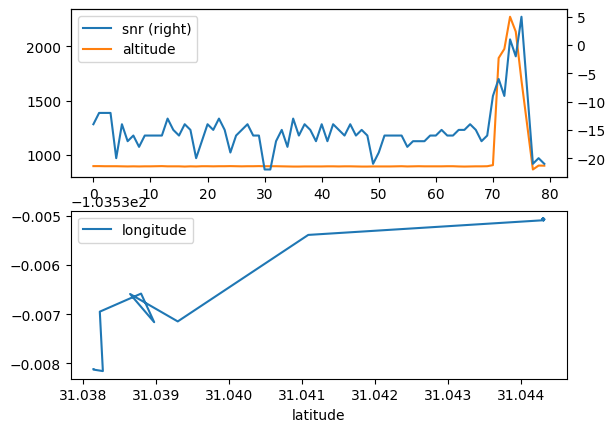

In [299]:
fig, (ax1 ,ax2) = plt.subplots(2)
rdf[rdf.longitude < -100][['snr', 'altitude']].plot(secondary_y='snr', ax = ax1)
rdf[rdf.longitude < -100][['latitude', 'longitude']].plot(x='latitude', ax = ax2)

<Axes: title={'center': 'Engineering Camera Accelerometer'}, xlabel='Time (s)', ylabel='Acceleration (g)'>

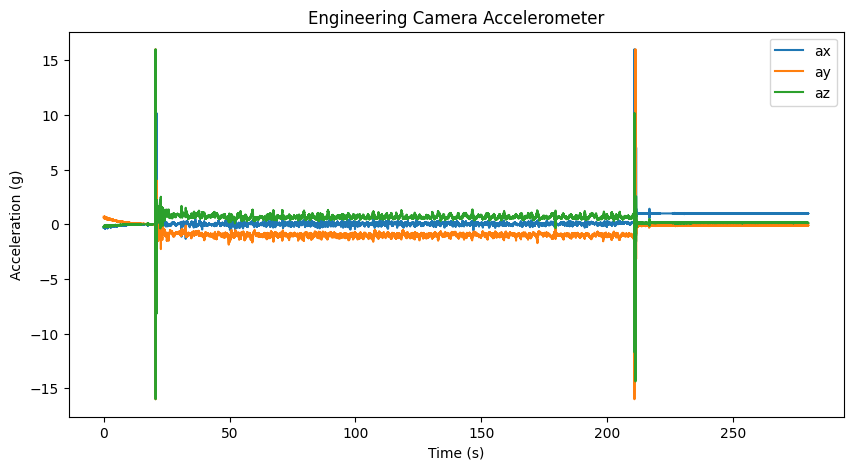

In [593]:
camdf.set_index('t')[['ax', 'ay', 'az']].loc[:280].plot(figsize=(10,5), title="Engineering Camera Accelerometer", ylabel='Acceleration (g)', xlabel="Time (s)")

<Axes: title={'center': 'Engineering Camera Gyroscope'}, xlabel='Time (s)', ylabel='Gyroscope (rad/s)'>

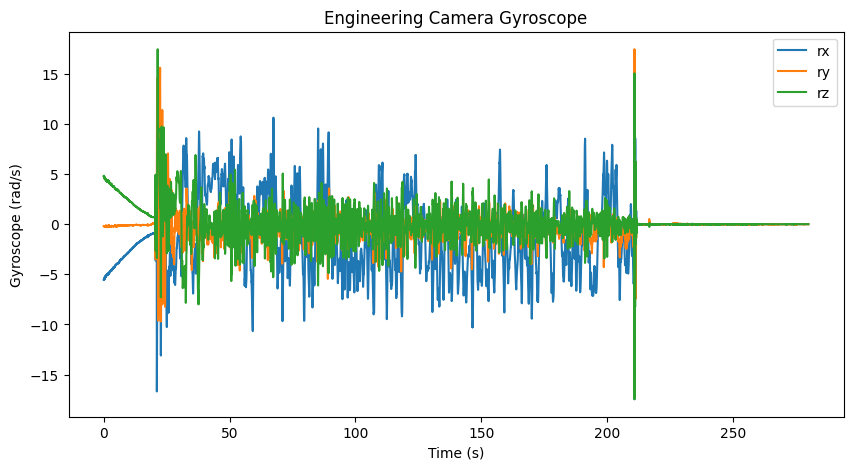

In [597]:
camdf.set_index('t')[['rx', 'ry', 'rz']].loc[:280].plot(figsize=(10,5), title="Engineering Camera Gyroscope", ylabel='Gyroscope (rad/s)', xlabel="Time (s)")

In [392]:
fdf[fdf.TRACKER == '<T144RITrk>'][['TIME', 'Alt AGL (ft)']].to_csv('~/Clubs/Launch/Misc/flight-data/2025/OTIS/rocket_received.csv')

In [345]:
fdf2.drop(columns=['vel_diff', 'ACC']).to_csv('/home/unknown/Camera/CSVs/payload_featherweight')

In [349]:
fastdf.drop(columns=['acc_mag']).to_csv('/home/unknown/Camera/CSVs/freaky_fast.csv')

In [374]:
def read_gcsv(input_file, output_file):
    gscale = 0
    ascale = 0
    tscale = 0

    initial_comment = ''

    with open(input_file, 'r') as f:
        while True:
            l = f.readline()
            if l.startswith('gscale'):
                gscale = float(l.split(',')[1])
            elif l.startswith('ascale'):
                ascale = float(l.split(',')[1])
            elif l.startswith('tscale'):
                tscale = float(l.split(',')[1])
            else:
                initial_comment+='# ' + l
            if (gscale != 0 and tscale != 0 and ascale!=0):
                break
        camdf = pd.read_csv(f)
    camdf['t'] = camdf['t'].map(lambda t : t * tscale)

    camdf['rx'] = camdf['rx'].map(lambda g : g * gscale)
    camdf['ry'] = camdf['ry'].map(lambda g : g * gscale)
    camdf['rz'] = camdf['rz'].map(lambda g : g * gscale)

    camdf['ax'] = camdf['ax'].map(lambda a : a * ascale)
    camdf['ay'] = camdf['ay'].map(lambda a : a * ascale)
    camdf['az'] = camdf['az'].map(lambda a : a * ascale)
    with open(output_file, 'w') as of:
        of.write(initial_comment)
        camdf.to_csv(of, index=False)
    return camdf

In [402]:
camdf = read_gcsv('/home/unknown/Camera/CSVs/camera.gcsv', '/home/unknown/Camera/CSVs/camera.csv')

In [418]:
camdf

,t,rx,ry,rz,ax,ay,az
0,0.000,-5.527657,-0.193345,4.797418,-0.336426,0.681641,-0.197266
1,0.001,-5.524994,-0.196541,4.799016,-0.312988,0.665527,-0.194336
2,0.002,-5.522331,-0.198139,4.798484,-0.300293,0.647461,-0.200684
3,0.003,-5.527124,-0.204531,4.791027,-0.293457,0.633789,-0.198242
4,0.004,-5.522863,-0.209857,4.787831,-0.304199,0.619141,-0.196289
...,...,...,...,...,...,...,...
674258,674.258,0.008522,0.001598,0.016512,0.987305,-0.106934,0.121582
674259,674.259,0.008522,0.002131,0.017577,0.987793,-0.107422,0.120117
674260,674.260,0.009055,0.002131,0.017577,0.987793,-0.107422,0.120117
674261,674.261,0.010120,0.001598,0.018642,0.988281,-0.107422,0.121094


<Axes: xlabel='t'>

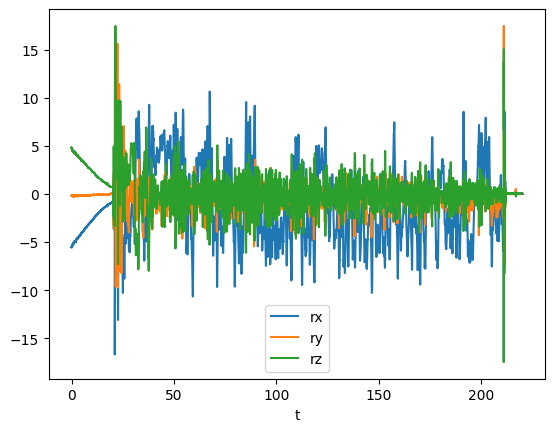

In [419]:
camdf.set_index('t')[['rx', 'ry', 'rz']].iloc[:220000].plot()

<Axes: xlabel='t'>

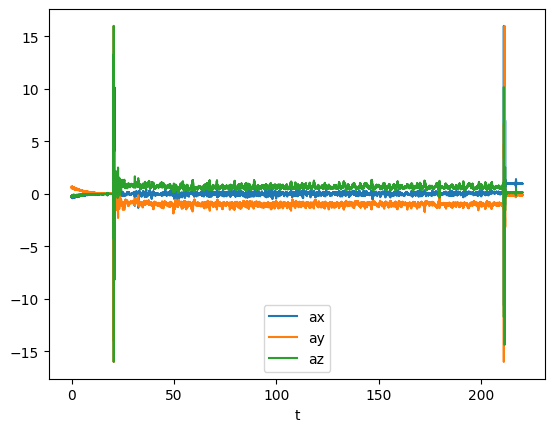

In [416]:
camdf.set_index('t')[['ax', 'ay', 'az']].iloc[:220000].plot()

In [376]:
read_gcsv('/home/unknown/Clubs/Launch/Misc/flight-data/2025/LILGUYs/main_bay_lilguy.gcsv', '/home/unknown/Clubs/Launch/Misc/flight-data/2025/LILGUYs/main_bay_lilguy.csv')

,t,rx,ry,rz,ax,ay,az
0,0.000,-0.779241,0.082558,-6.910903,0.033203,-0.208496,0.621094
1,0.001,-0.780306,0.083091,-6.909838,0.050293,-0.208496,0.609375
2,0.002,-0.778708,0.084689,-6.910370,0.087402,-0.162109,0.601074
3,0.003,-0.779774,0.083623,-6.911436,0.064453,-0.158203,0.585938
4,0.004,-0.779241,0.085221,-6.909305,0.048828,-0.163574,0.573730
...,...,...,...,...,...,...,...
674273,674.273,-0.023968,0.004794,0.025034,-0.392578,-0.902344,0.211914
674274,674.274,-0.023436,0.004794,0.025034,-0.392578,-0.901855,0.211914
674275,674.275,-0.023436,0.005859,0.025034,-0.393066,-0.901855,0.210938
674276,674.276,-0.023436,0.005859,0.026099,-0.394043,-0.901855,0.210938


In [377]:
read_gcsv('/home/unknown/Clubs/Launch/Misc/flight-data/2025/LILGUYs/other_bay_lilguy.gcsv', '/home/unknown/Clubs/Launch/Misc/flight-data/2025/LILGUYs/other_bay_lilguy.csv')

,t,rx,ry,rz,ax,ay,az
0,0.000,-0.384560,-0.479902,7.156979,-0.305176,-0.087402,-0.555176
1,0.001,-0.386158,-0.480967,7.151120,-0.314941,-0.064453,-0.553223
2,0.002,-0.388822,-0.482565,7.146859,-0.340820,-0.050781,-0.562012
3,0.003,-0.390419,-0.484695,7.148990,-0.349121,-0.048828,-0.568359
4,0.004,-0.392017,-0.485761,7.150055,-0.333008,-0.075195,-0.586426
...,...,...,...,...,...,...,...
674242,674.242,0.009587,-0.003728,0.017044,0.980469,-0.138184,-0.103516
674243,674.243,0.010120,-0.003728,0.015979,0.980469,-0.138184,-0.104004
674244,674.244,0.009587,-0.004794,0.017044,0.980469,-0.137695,-0.104492
674245,674.245,0.009587,-0.004794,0.017044,0.980469,-0.137207,-0.104492


<Axes: xlabel='Time'>

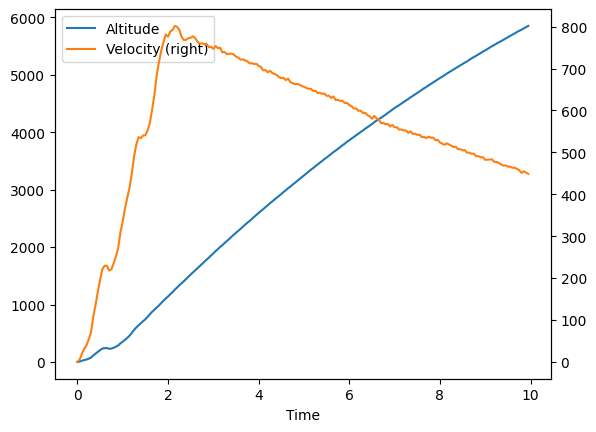

In [401]:
pd.read_csv('/home/unknown/Clubs/Launch/Misc/flight-data/2025/OTIS/RRC3/OTIS Secondary RRC3.csv').set_index('Time')[['Altitude', 'Velocity']].iloc[:200].plot(secondary_y = 'Velocity')

<Axes: xlabel='seconds'>

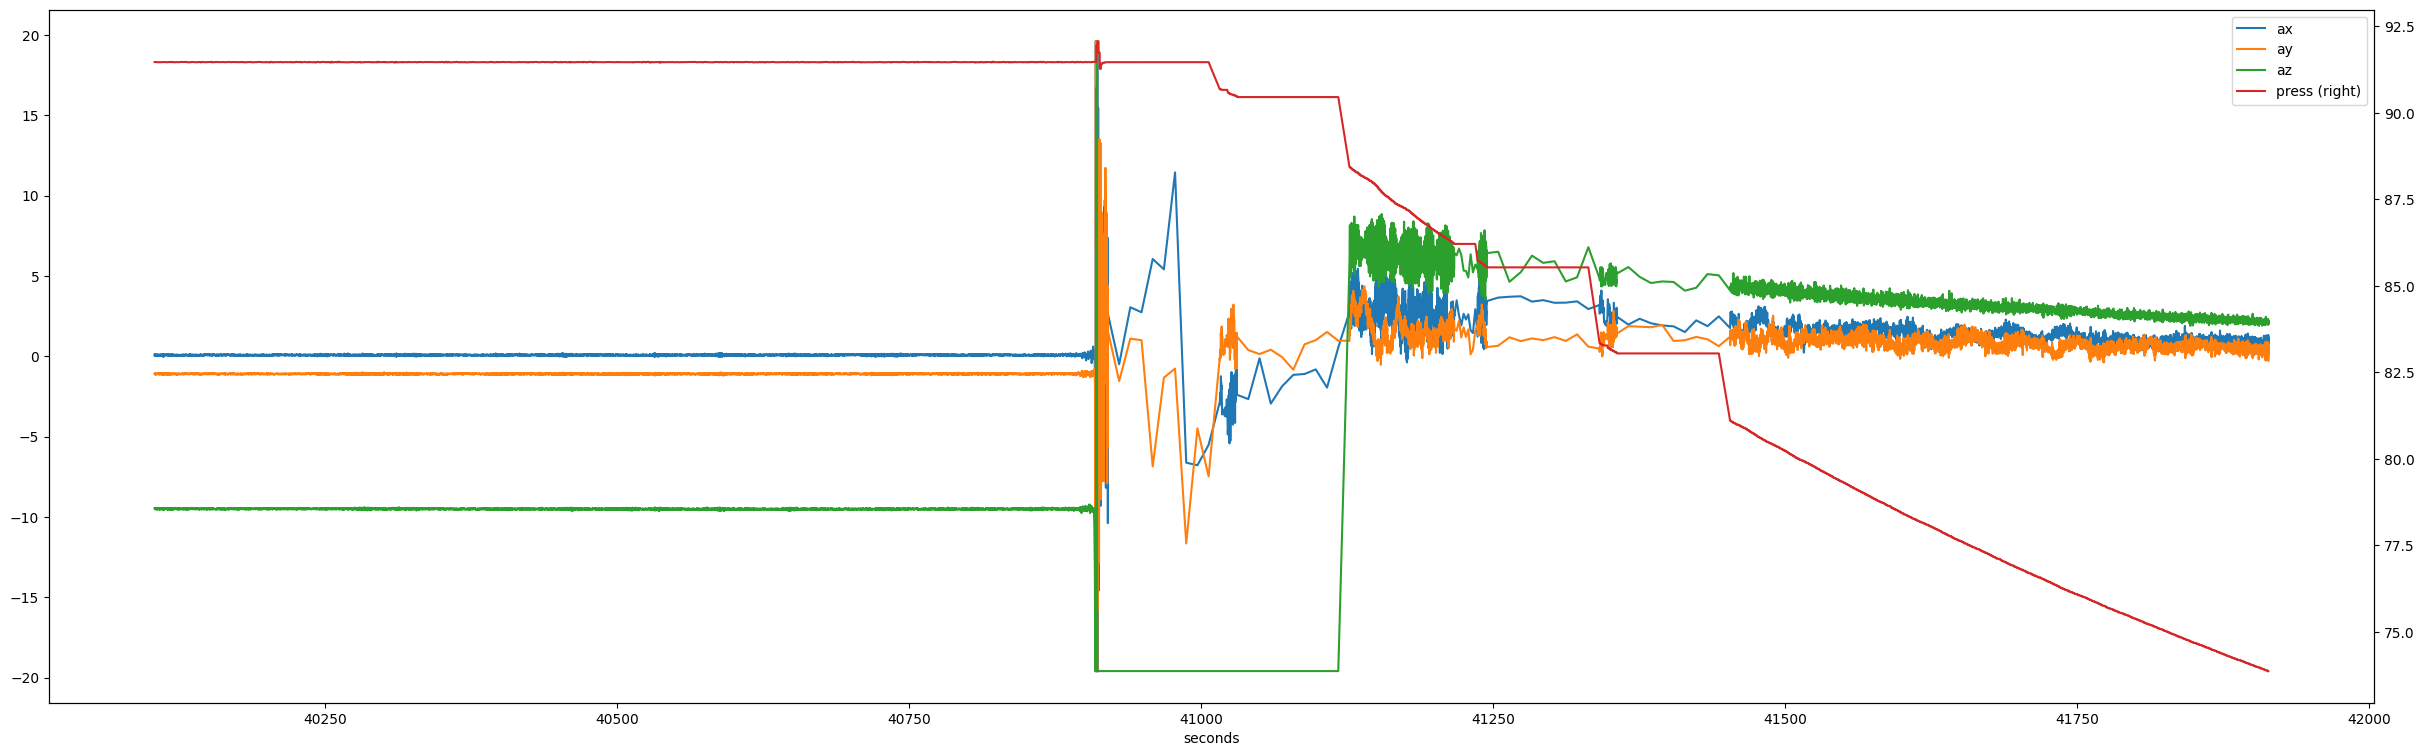

In [435]:
fastdf.set_index('seconds')[['ax', 'ay', 'az', 'press']].iloc[401000:].plot(secondary_y='press', figsize=(30,9))

<Axes: >

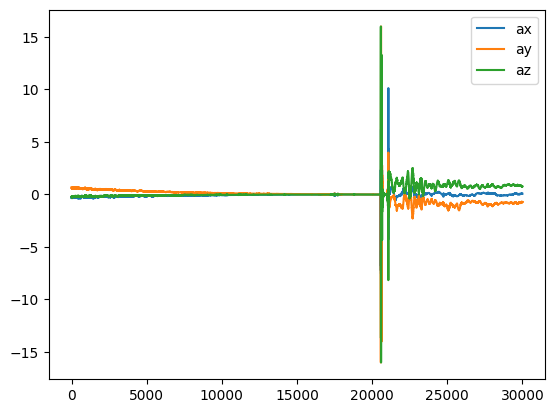

In [442]:
camdf[['ax', 'ay', 'az']].iloc[:30000].plot()

In [ ]:
pd.DataFrame.from_records(fast_pacs)
fast

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1806933700,91.470772,35.108643,0.017944,-0.034437,0.003436,0.006108,-0.037262,0.023976,0.010842,...,-9.492925,0.036490,-1.124626,-9.519246,0.020937,-1.119840,-9.488738,0.046660,-1.080957,-9.480961
3,1806943700,91.476387,35.113220,0.014660,-0.033444,0.027794,0.016035,-0.022067,-0.015271,0.011301,...,-9.516853,0.049052,-1.119242,-9.476773,0.047258,-1.127617,-9.488738,0.068793,-1.105484,-9.478568
4,1806953700,91.473068,35.108643,0.020845,-0.027717,0.023060,0.000839,-0.030085,-0.036804,0.013209,...,-9.490532,0.083150,-1.101296,-9.489336,0.040079,-1.102493,-9.472586,0.067597,-1.110269,-9.468399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41499,2226028700,73.913330,35.895920,-0.148669,-0.087124,-2.501798,-0.150120,-0.089491,-2.501798,-0.136833,...,2.085943,0.713659,0.397208,2.222932,0.925424,0.230907,2.050648,0.945164,0.604187,2.162513
41500,2226038700,73.894089,35.891342,-0.149661,-0.112399,-2.501798,-0.166308,-0.046578,-2.501798,-0.152028,...,2.280958,0.483350,-0.064008,1.959123,0.160917,0.129212,2.123031,0.815952,0.041874,2.454437
41501,2226048700,73.888031,35.895920,-0.162490,-0.063682,-2.501798,-0.139200,-0.100487,-2.501798,-0.127747,...,2.116451,0.927218,0.209970,2.030309,1.107278,0.849452,2.079961,1.139581,0.665204,2.204387
41502,2226058700,73.875908,35.905075,-0.159206,-0.077121,-2.501798,-0.169133,-0.099036,-2.501798,-0.143935,...,2.304886,0.183050,-0.153738,2.261815,0.658026,0.404985,2.295913,0.379860,0.138783,2.196611
